In [45]:
from pyspark.sql.types import *
from pyspark.sql.functions import udf,monotonically_increasing_id as mID,isnull
from pyspark.ml.feature import StringIndexer
from pyspark.mllib.tree import GradientBoostedTrees
from pyspark.mllib.classification import LabeledPoint
from pyspark.mllib.evaluation import BinaryClassificationMetrics as bcm

from IPython.display import display
import pandas as pd
import numpy as np
from scipy.stats import fisher_exact
import matplotlib.pyplot as plt

import loo_ndarray_version as loo

In [2]:
f = open('kddcup.names')
columns = f.readlines()
f.close()

columns = columns[1:]
fields = []
for c in columns:
    c = c.replace('\n','')
    c = c.replace('.','')
    c = c.split(': ')
    if(c[1] == 'continuous'):
        fields.append(StructField(c[0],FloatType()))
    elif(c[1]=='symbolic'):
        fields.append(StructField(c[0],StringType()))

fields.append(StructField('outcome',StringType()))
schema = StructType(fields)

In [3]:
df = spark.read.csv('hdfs://localhost:9000/data/kddcup.data.corrected', header=False, mode='DROPMALFORMED',schema=schema)
# treat categorical features
si = StringIndexer(inputCol='protocol_type',outputCol='protocol_type_index',handleInvalid='error')
protocol_type = si.fit(df)
si = StringIndexer(inputCol='logged_in',outputCol='logged_in_index',handleInvalid='error')
logged_in = si.fit(df)
df = protocol_type.transform(df)
df = logged_in.transform(df)

df = df.drop('logged_in')
df = df.drop('protocol_type')

df = df.sample(withReplacement=False,fraction=0.2,seed=1028)
df.first()

Row(duration=0.0, service=u'http', flag=u'SF', src_bytes=215.0, dst_bytes=45076.0, land=u'0', wrong_fragment=0.0, urgent=0.0, hot=0.0, num_failed_logins=0.0, num_compromised=0.0, root_shell=0.0, su_attempted=0.0, num_root=0.0, num_file_creations=0.0, num_shells=0.0, num_access_files=0.0, num_outbound_cmds=0.0, is_host_login=u'0', is_guest_login=u'0', count=1.0, srv_count=1.0, serror_rate=0.0, srv_serror_rate=0.0, rerror_rate=0.0, srv_rerror_rate=0.0, same_srv_rate=1.0, diff_srv_rate=0.0, srv_diff_host_rate=0.0, dst_host_count=0.0, dst_host_srv_count=0.0, dst_host_same_srv_rate=0.0, dst_host_diff_srv_rate=0.0, dst_host_same_src_port_rate=0.0, dst_host_srv_diff_host_rate=0.0, dst_host_serror_rate=0.0, dst_host_srv_serror_rate=0.0, dst_host_rerror_rate=0.0, dst_host_srv_rerror_rate=0.0, outcome=u'normal.', protocol_type_index=1.0, logged_in_index=1.0)

In [4]:
removeP = udf(lambda x: x.replace('.',''),StringType())
makeBinary = udf(lambda x: 1 if x!='normal' else 0,IntegerType())
df = df.withColumn('outcome',removeP('outcome'))
df = df.withColumn('binary_outcome',makeBinary('outcome'))
df = df.withColumn('id',mID())

In [18]:
df.createOrReplaceTempView('df')
spark.sql('select binary_outcome,count(*) as count, round(100*count(*)/(select count(*) from df),4) as pct from df group by binary_outcome').show()
spark.sql('select outcome,count(*) as count, round(100*count(*)/(select count(*) from df),4) as pct from df group by outcome').show(100)

+--------------+-------+------+
|binary_outcome|  count|   pct|
+--------------+-------+------+
|             1|3925650|80.141|
|             0| 972781|19.859|
+--------------+-------+------+

+---------------+-------+-------+
|        outcome|  count|    pct|
+---------------+-------+-------+
|        neptune|1072017|21.8849|
|          satan|  15892| 0.3244|
|           nmap|   2316| 0.0473|
|      portsweep|  10413| 0.2126|
|           back|   2203|  0.045|
|    warezclient|   1020| 0.0208|
|   guess_passwd|     53| 0.0011|
|         normal| 972781| 19.859|
|        rootkit|     10| 2.0E-4|
|           perl|      3| 1.0E-4|
|buffer_overflow|     30| 6.0E-4|
|       multihop|      7| 1.0E-4|
|        ipsweep|  12481| 0.2548|
|    warezmaster|     20| 4.0E-4|
|           imap|     12| 2.0E-4|
|       teardrop|    979|   0.02|
|            spy|      2|    0.0|
|           land|     21| 4.0E-4|
|            pod|    264| 0.0054|
|      ftp_write|      8| 2.0E-4|
|          smurf|2807886|

,num_access_files
count,4.898431e+06
mean,1.021143e-03
std,3.551048e-02
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,9.000000e+00


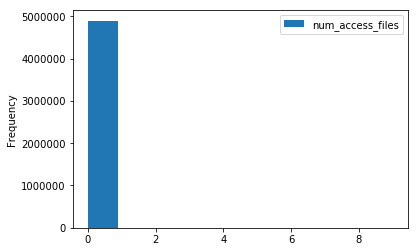

,src_bytes
count,4.898431e+06
mean,1.834621e+03
std,9.414311e+05
min,0.000000e+00
25%,4.500000e+01
50%,5.200000e+02
75%,1.032000e+03
max,1.379964e+09


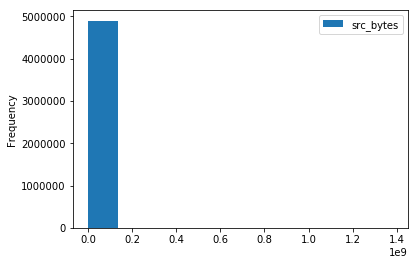

,srv_count
count,4.898431e+06
mean,2.952671e+02
std,2.459927e+02
min,0.000000e+00
25%,1.000000e+01
50%,5.100000e+02
75%,5.110000e+02
max,5.110000e+02


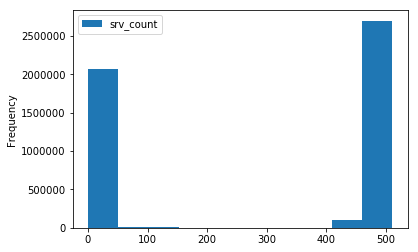

,num_compromised
count,4.898431e+06
mean,8.088304e-03
std,3.856481e+00
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,7.479000e+03


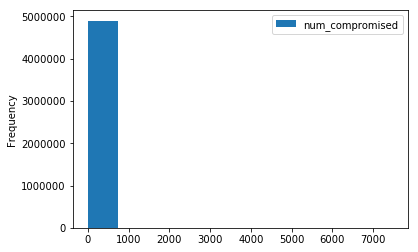

,rerror_rate
count,4.898431e+06
mean,5.766509e-02
std,2.322529e-01
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,1.000000e+00


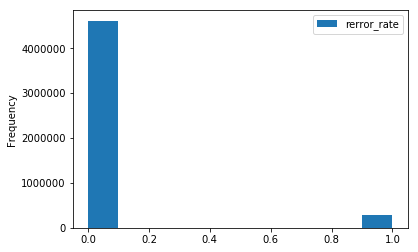

,urgent
count,4.898431e+06
mean,7.961733e-06
std,7.215084e-03
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,1.400000e+01


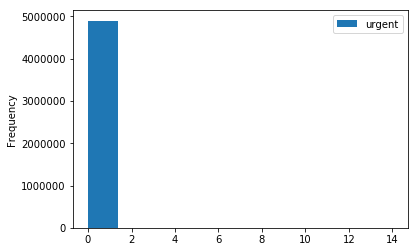

,dst_host_same_srv_rate
count,4.898431e+06
mean,7.537132e-01
std,4.111860e-01
min,0.000000e+00
25%,4.100000e-01
50%,1.000000e+00
75%,1.000000e+00
max,1.000000e+00


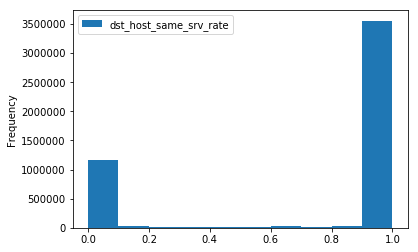

,duration
count,4.898431e+06
mean,4.834243e+01
std,7.233298e+02
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,5.832900e+04


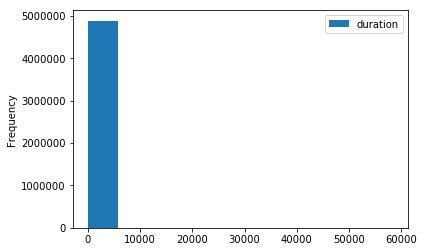

,srv_serror_rate
count,4.898431e+06
mean,1.780370e-01
std,3.822541e-01
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,1.000000e+00


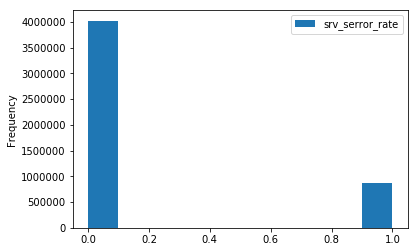

+-------------+-------+
|is_host_login|  count|
+-------------+-------+
|            0|4898429|
|            1|      2|
+-------------+-------+



None

,wrong_fragment
count,4.898431e+06
mean,6.487792e-04
std,4.285434e-02
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,3.000000e+00


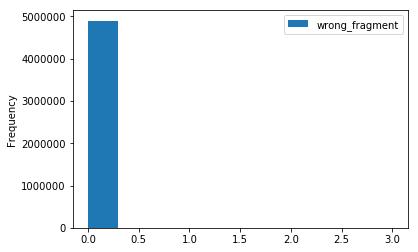

+-----------+-------+
|    service|  count|
+-----------+-------+
|     telnet|   4277|
|        ftp|   5214|
|       auth|   3382|
|   iso_tsap|   1052|
|     systat|   1056|
|       name|   1067|
|    sql_net|   1052|
|      ntp_u|   3833|
|        X11|    135|
|      pop_3|   1981|
|       ldap|   1041|
|    discard|   1059|
|     tftp_u|      3|
|     Z39_50|   1078|
|    daytime|   1056|
|   domain_u|  57782|
|      login|   1045|
|       smtp|  96554|
|  http_2784|      1|
|        mtp|   1076|
|     domain|   1113|
|       http| 623091|
|    harvest|      2|
|       link|   1069|
|    courier|   1021|
|     kshell|   1040|
|      pop_2|   1055|
|      other|  72653|
|       exec|   1045|
|       nnsp|   1038|
|        efs|   1042|
|        IRC|    521|
|    pm_dump|      5|
|    private|1100831|
|      urh_i|    148|
|   ftp_data|  40697|
|      whois|   1073|
|       nntp|   1059|
| netbios_ns|   1054|
|        aol|      2|
|     klogin|   1050|
|      shell|   1051|
|      red

None

,serror_rate
count,4.898431e+06
mean,1.779703e-01
std,3.818756e-01
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,1.000000e+00


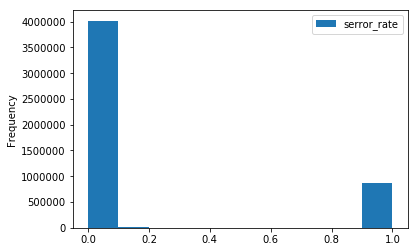

,num_outbound_cmds
count,4898431.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


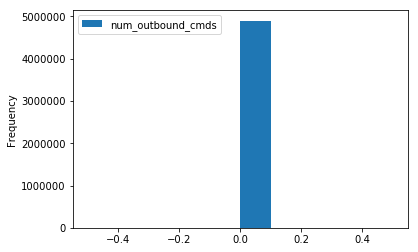

+--------------+-------+
|is_guest_login|  count|
+--------------+-------+
|             0|4894340|
|             1|   4091|
+--------------+-------+



None

,dst_host_rerror_rate
count,4.898431e+06
mean,5.792780e-02
std,2.309428e-01
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,1.000000e+00


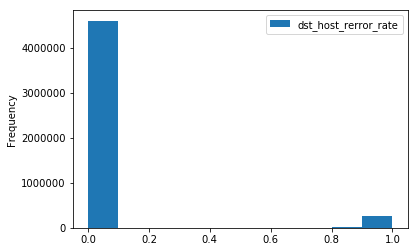

,dst_host_srv_serror_rate
count,4.898431e+06
mean,1.778859e-01
std,3.821774e-01
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,1.000000e+00


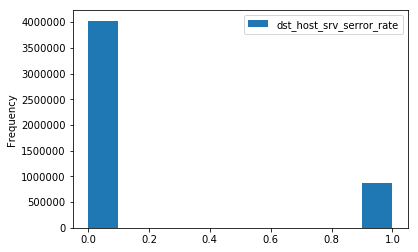

,hot
count,4.898431e+06
mean,1.243766e-02
std,4.689782e-01
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,7.700000e+01


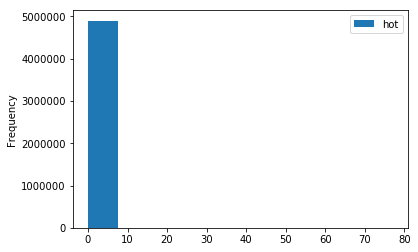

,dst_host_srv_count
count,4.898431e+06
mean,1.892142e+02
std,1.059128e+02
min,0.000000e+00
25%,4.900000e+01
50%,2.550000e+02
75%,2.550000e+02
max,2.550000e+02


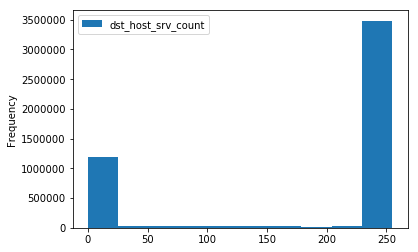

+---------+-------+
|logged_in|  count|
+---------+-------+
|        0|4195364|
|        1| 703067|
+---------+-------+



None

,srv_rerror_rate
count,4.898431e+06
mean,5.773010e-02
std,2.326604e-01
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,1.000000e+00


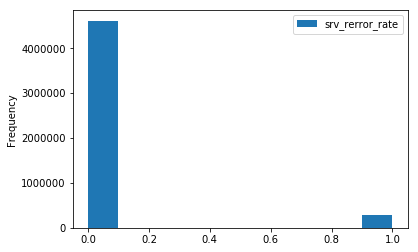

,dst_host_srv_diff_host_rate
count,4.898431e+06
mean,6.464107e-03
std,4.125978e-02
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,1.000000e+00


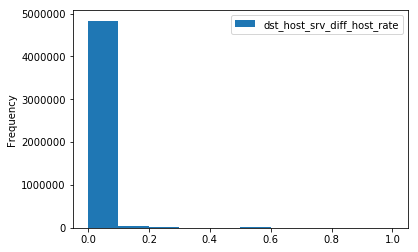

,num_root
count,4.898431e+06
mean,1.293496e-02
std,3.938075e+00
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,7.468000e+03


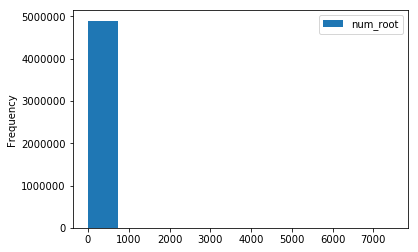

,dst_host_same_src_port_rate
count,4.898431e+06
mean,6.050520e-01
std,4.809877e-01
min,0.000000e+00
25%,0.000000e+00
50%,1.000000e+00
75%,1.000000e+00
max,1.000000e+00


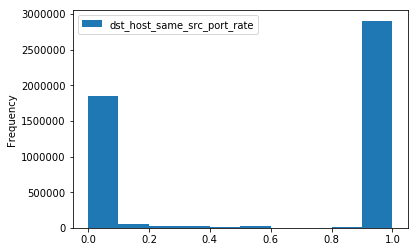

,root_shell
count,4.898431e+06
mean,6.818510e-05
std,8.257146e-03
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,1.000000e+00


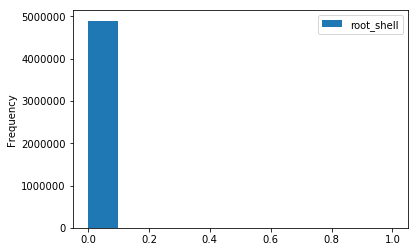

+------+-------+
|  flag|  count|
+------+-------+
|RSTOS0|    122|
|    S3|     50|
|    SF|3744328|
|    S0| 869829|
|   OTH|     57|
|   REJ| 268874|
|  RSTO|   5344|
|  RSTR|   8094|
|    SH|   1040|
|    S2|    161|
|    S1|    532|
+------+-------+



None

,su_attempted
count,4.898431e+06
mean,3.674646e-05
std,8.082432e-03
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,2.000000e+00


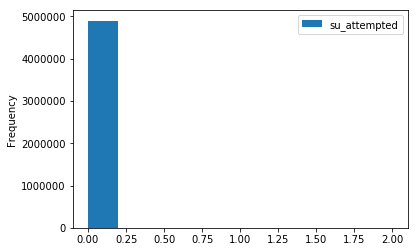

,dst_host_count
count,4.898431e+06
mean,2.329811e+02
std,6.402094e+01
min,0.000000e+00
25%,2.550000e+02
50%,2.550000e+02
75%,2.550000e+02
max,2.550000e+02


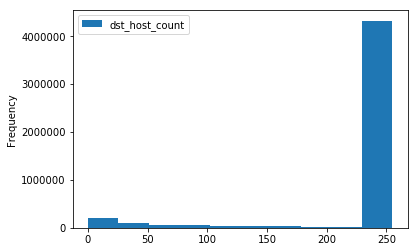

,num_file_creations
count,4.898431e+06
mean,1.188748e-03
std,1.241857e-01
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,4.300000e+01


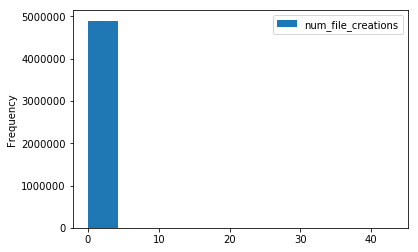

+-------------+-------+
|protocol_type|  count|
+-------------+-------+
|          tcp|1870598|
|          udp| 194288|
|         icmp|2833545|
+-------------+-------+



None

,count
count,4.898431e+06
mean,3.349734e+02
std,2.119908e+02
min,0.000000e+00
25%,1.210000e+02
50%,5.100000e+02
75%,5.110000e+02
max,5.110000e+02


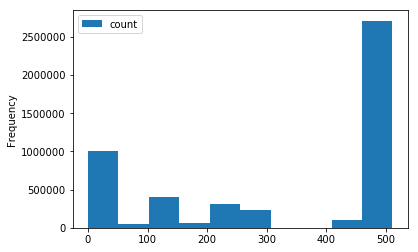

+----+-------+
|land|  count|
+----+-------+
|   0|4898403|
|   1|     28|
+----+-------+



None

,same_srv_rate
count,4.898431e+06
mean,7.898842e-01
std,3.892958e-01
min,0.000000e+00
25%,1.000000e+00
50%,1.000000e+00
75%,1.000000e+00
max,1.000000e+00


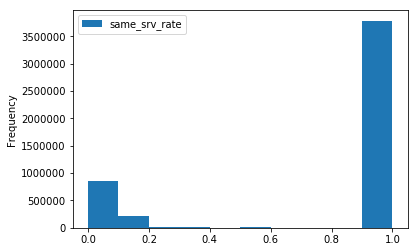

,num_failed_logins
count,4.898431e+06
mean,3.205108e-05
std,7.299408e-03
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,5.000000e+00


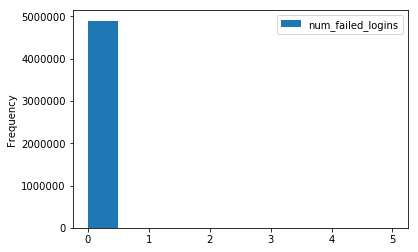

,num_shells
count,4.898431e+06
mean,7.430951e-05
std,8.737590e-03
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,2.000000e+00


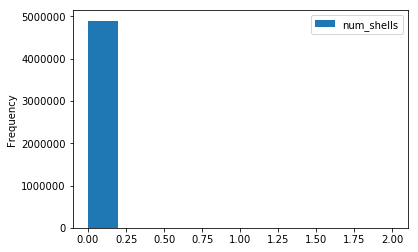

,dst_host_srv_rerror_rate
count,4.898431e+06
mean,5.765941e-02
std,2.309777e-01
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,1.000000e+00


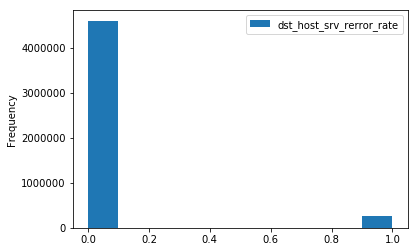

,srv_diff_host_rate
count,4.898431e+06
mean,2.826080e-02
std,1.405596e-01
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,1.000000e+00


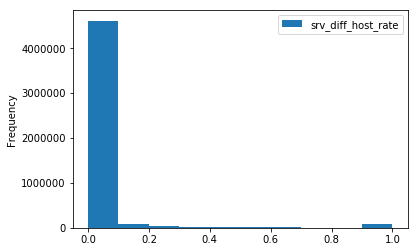

,diff_srv_rate
count,4.898431e+06
mean,2.117961e-02
std,8.271458e-02
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,1.000000e+00


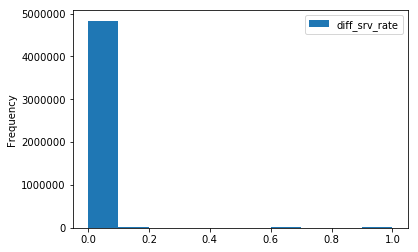

,dst_host_serror_rate
count,4.898431e+06
mean,1.780911e-01
std,3.818382e-01
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,1.000000e+00


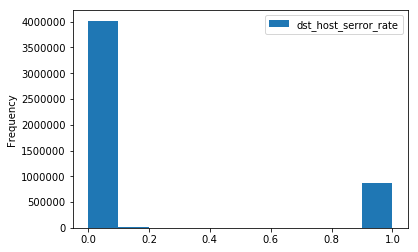

,dst_bytes
count,4.898431e+06
mean,1.093623e+03
std,6.450123e+05
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,1.309937e+09


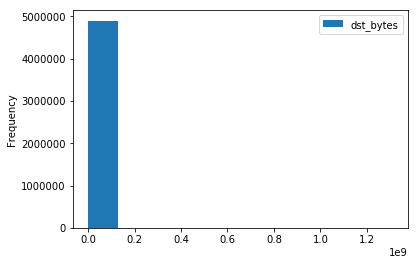

,dst_host_diff_srv_rate
count,4.898431e+06
mean,3.071111e-02
std,1.085432e-01
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,4.000000e-02
max,1.000000e+00


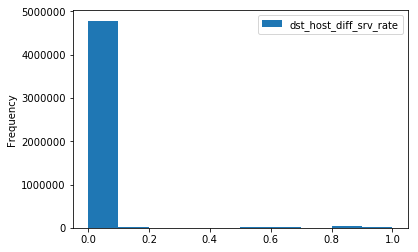

In [92]:
pd.options.display.max_columns=50
for c in set(df.columns)-set(['outcome','binary_outcome']):
    if(df[[c]].dtypes[0][1] != 'string'):
        display(df[[c]].toPandas().describe())
        df[[c]].toPandas().plot.hist()
        plt.show()
        plt.close()
    else:
        display(df[[c]].groupBy(c).count().show(100))

In [12]:
# drop these low information variables
for i in ('is_host_login','num_outbound_cmds','land'):
    df = df.drop(i)

In [13]:
exclude = ['outcome','binary_outcome','id']
loo_vars = ['service','flag']
loo_vars_new = ['loo_' + i for i in loo_vars]
model_vars = list(set(df.columns) - (set(loo_vars) | set(exclude)))

In [14]:
crossfolds = df.randomSplit(weights=np.repeat(10**-1,10),seed=1028)

In [17]:
fakeAUC = {'gbt':[]}

# cv with gradient boost
for i in range(len(crossfolds)):
    print 'Fold {} of {}'.format(i+1,len(crossfolds))
    
    subset = [x for x,y in zip(crossfolds,range(len(crossfolds))) if y!=i]
    subset = reduce(lambda x,y: x.unionAll(y),subset)
    subset = subset.select(['id','binary_outcome'] + loo_vars)
    
    print 'make LOO'
    ltab = loo.loo(df=subset.toPandas(),vars=loo_vars,yvar='binary_outcome')
    
    # In a true distributed environment this could probablyt be off loaded to clusters
    print 'collect resources'
    loo_df = df.select(['id','binary_outcome'] + loo_vars)
    train_ids = subset.rdd.map(lambda x: x['id']).collect()
    
    print 'get LOO columns'
    loo_res = ltab.applyLookup(df=loo_df.toPandas(),trainVar='id',trainValue=train_ids,keep=['id'])
    # attempt at mapped version
    #loo_res = loo_df.select(['id','binary_outcome'] + loo_vars).rdd.mapPartitions(lambda x: (ltab.applyLookup(pd.DataFrame(y.asDict(),index=[0]),'id',train_ids.value,keep=['id']) for y in x))

    loo_res = spark.createDataFrame(loo_res)
    print 'merge back'
    subset = subset.withColumn('train_ind',pyspark.sql.functions.lit('train'))
    final = df.select(model_vars + ['id','binary_outcome']).join(other=loo_res,on='id',how='inner')
    final = final.join(subset.select('id','train_ind'),on='id',how='left_outer')
    final.cache()
    
    print 'Create Labeled Points'
    train = final[final['train_ind']=='train'].rdd.map(lambda x: LabeledPoint(features=[x[f] for f in sorted(x.__fields__) if f not in ('id','binary_outcome','train_ind')],label=x['binary_outcome']))
    test = final[isnull(final['train_ind'])].rdd.map(lambda x: tuple([x[f] for f in sorted(x.__fields__) if f not in ('id','binary_outcome','train_ind')]))
    train.cache()
    test.cache()
    final.unpersist()
    
    print 'Fit Model'
    sorted_fields = set(final.columns) - set(['id','binary_outcome','train_ind'])
    sorted_fields = sorted(list(sorted_fields))
    feature_map = {[colInd for colInd in range(len(sorted_fields)) if sorted_fields[colInd] == 'logged_in_index'][0]:len(logged_in.labels),
              [colInd for colInd in range(len(sorted_fields)) if sorted_fields[colInd] == 'protocol_type_index'][0]:len(protocol_type.labels)}
    fit = GradientBoostedTrees.trainClassifier(categoricalFeaturesInfo=feature_map,data=train,learningRate=0.1,maxBins=32,maxDepth=1)
    preds = fit.predict(test)
    perf = bcm(sc.parallelize(zip(preds.collect(),final[isnull(final['train_ind'])].rdd.map(lambda x: float(x['binary_outcome'])).collect())))
    fakeAUC['gbt'].append(perf.areaUnderROC)
    
    train.unpersist()
    test.unpersist()
    del train,test,train_ids,preds,final,subset,loo_res,loo_df,perf

Fold 1 of 10
make LOO
collect resources
get LOO columns
merge back
Create Labeled Points
Fit Model


Py4JJavaError: An error occurred while calling o396.trainGradientBoostedTreesModel.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 2 in stage 32.0 failed 1 times, most recent failure: Lost task 2.0 in stage 32.0 (TID 763, localhost, executor driver): java.lang.IllegalArgumentException: DecisionTree given invalid data: Feature 20 is categorical with values in {0,...,2, but a data point gives it value 4.0.
  Bad data point: (-1.0,[1.0,0.0,7542.0,48.0,0.0,0.0,0.019999999552965164,1.0,0.0,255.0,0.029999999329447746,0.0,0.0,0.0,4.0,0.0,1.0,0.8646538041861086,0.007717610783629696,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,265.0,4.0,0.5,0.0,0.0,0.0,0.0,0.0])
	at org.apache.spark.ml.tree.impl.TreePoint$.findBin(TreePoint.scala:124)
	at org.apache.spark.ml.tree.impl.TreePoint$.org$apache$spark$ml$tree$impl$TreePoint$$labeledPointToTreePoint(TreePoint.scala:93)
	at org.apache.spark.ml.tree.impl.TreePoint$$anonfun$convertToTreeRDD$2.apply(TreePoint.scala:73)
	at org.apache.spark.ml.tree.impl.TreePoint$$anonfun$convertToTreeRDD$2.apply(TreePoint.scala:72)
	at scala.collection.Iterator$$anon$11.next(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.next(Iterator.scala:409)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsValues(MemoryStore.scala:216)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:957)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:948)
	at org.apache.spark.storage.BlockManager.doPut(BlockManager.scala:888)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:948)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:694)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:334)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:285)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:96)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.scheduler.Task.run(Task.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:282)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	at java.lang.Thread.run(Thread.java:745)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1435)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1423)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1422)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1422)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:802)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:802)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1650)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1605)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1594)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:628)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1918)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1931)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1944)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1958)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:935)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:362)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:934)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$collectAsMap$1.apply(PairRDDFunctions.scala:748)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$collectAsMap$1.apply(PairRDDFunctions.scala:747)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:362)
	at org.apache.spark.rdd.PairRDDFunctions.collectAsMap(PairRDDFunctions.scala:747)
	at org.apache.spark.ml.tree.impl.RandomForest$.findBestSplits(RandomForest.scala:563)
	at org.apache.spark.ml.tree.impl.RandomForest$.run(RandomForest.scala:198)
	at org.apache.spark.ml.regression.DecisionTreeRegressor.train(DecisionTreeRegressor.scala:125)
	at org.apache.spark.ml.tree.impl.GradientBoostedTrees$.boost(GradientBoostedTrees.scala:291)
	at org.apache.spark.ml.tree.impl.GradientBoostedTrees$.run(GradientBoostedTrees.scala:53)
	at org.apache.spark.mllib.tree.GradientBoostedTrees.run(GradientBoostedTrees.scala:70)
	at org.apache.spark.mllib.tree.GradientBoostedTrees$.train(GradientBoostedTrees.scala:135)
	at org.apache.spark.mllib.api.python.PythonMLLibAPI.trainGradientBoostedTreesModel(PythonMLLibAPI.scala:814)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:745)
Caused by: java.lang.IllegalArgumentException: DecisionTree given invalid data: Feature 20 is categorical with values in {0,...,2, but a data point gives it value 4.0.
  Bad data point: (-1.0,[1.0,0.0,7542.0,48.0,0.0,0.0,0.019999999552965164,1.0,0.0,255.0,0.029999999329447746,0.0,0.0,0.0,4.0,0.0,1.0,0.8646538041861086,0.007717610783629696,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,265.0,4.0,0.5,0.0,0.0,0.0,0.0,0.0])
	at org.apache.spark.ml.tree.impl.TreePoint$.findBin(TreePoint.scala:124)
	at org.apache.spark.ml.tree.impl.TreePoint$.org$apache$spark$ml$tree$impl$TreePoint$$labeledPointToTreePoint(TreePoint.scala:93)
	at org.apache.spark.ml.tree.impl.TreePoint$$anonfun$convertToTreeRDD$2.apply(TreePoint.scala:73)
	at org.apache.spark.ml.tree.impl.TreePoint$$anonfun$convertToTreeRDD$2.apply(TreePoint.scala:72)
	at scala.collection.Iterator$$anon$11.next(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.next(Iterator.scala:409)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsValues(MemoryStore.scala:216)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:957)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:948)
	at org.apache.spark.storage.BlockManager.doPut(BlockManager.scala:888)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:948)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:694)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:334)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:285)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:96)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.scheduler.Task.run(Task.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:282)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	... 1 more


In [ ]:
fakeAUC